In [2]:
%run StarterCode.ipynb
local_traffic_merged = traffic_merged.copy()

In [3]:
local_traffic_merged.sort_values('TIME', ascending=True)
print(local_traffic_merged.shape)
print(local_traffic_merged.columns)

(2577601, 29)
Index(['TIME', 'SEGMENTID', 'BUS COUNT                ', 'MESSAGE COUNT',
       'SPEED', 'datetime', 'name', 'temp', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'conditions',
       'icon', 'stations'],
      dtype='object')


**Cleaning the Data**:
   - **Missing values**: Check for any missing or NaN values in the dataset. 
  
At this point we see that we have 29 features with the names as seen above. First, we take a look at the missing values:

In [4]:
print(local_traffic_merged.isnull().sum())

TIME                               0
SEGMENTID                          0
BUS COUNT                          0
MESSAGE COUNT                      0
SPEED                              0
datetime                           0
name                          126557
temp                          126557
feelslike                     126557
dew                           126557
humidity                      126557
precip                        126557
precipprob                    126557
preciptype                   2306808
snow                          126557
snowdepth                     126557
windgust                      126557
windspeed                     126557
winddir                       126557
sealevelpressure              126557
cloudcover                    126557
visibility                    126557
solarradiation                126557
solarenergy                   126557
uvindex                       126557
severerisk                   2577601
conditions                    126557
i

Dealing with following columns: 'name', 'severerisk', 'stations', 'datetime'
I will be dropping them because they are definitely not relevant to our analysis

In [5]:
# strip whitespace from column names
local_traffic_merged.columns = local_traffic_merged.columns.str.strip()

# drop the columns 
local_traffic_merged.drop(['name', 'severerisk', 'stations', 'datetime'], axis=1, inplace=True)

In [6]:
print(local_traffic_merged.shape)

(2577601, 25)


Now we 
1. Loop through each column in the DataFrame
2. Count the number of NaN values 
3. Forward fill and backward fill to handle NaN values
4. Check if there are still NaN values after ffill and bfill
5. Fill the remaining NaNs with the most common value



In [7]:
for column in local_traffic_merged.columns:
    nan_count_before = local_traffic_merged[column].isnull().sum()
    if nan_count_before > 0:
        print(f"Processing column: {column}")

        local_traffic_merged[column] = local_traffic_merged[column].ffill().bfill()

        most_common_value = local_traffic_merged[column].mode()[0]

        nan_count_after = local_traffic_merged[column].isnull().sum()
        if nan_count_after > 0:
            local_traffic_merged[column].fillna(most_common_value, inplace=True)

        if local_traffic_merged[column].isnull().any():
            raise Exception(f"NaN values still present in {column} after filling!")

        unique_values = local_traffic_merged[column].unique()[:10]
        nan_filled = nan_count_before - nan_count_after

        print(f"Used '{most_common_value}' to fill {nan_filled} NaNs in {column}")
        print(f"First 10 unique values in {column} after filling NaNs: {unique_values}\n")

Processing column: temp
Used '33.9' to fill 126557 NaNs in temp
First 10 unique values in temp after filling NaNs: [67.2 69.6 72.1 74.9 78.2 79.1 79.7 77.8 74.7 72.7]

Processing column: feelslike
Used '31.5' to fill 126557 NaNs in feelslike
First 10 unique values in feelslike after filling NaNs: [67.2 69.6 72.1 74.9 78.2 79.1 79.7 77.8 74.7 72.7]

Processing column: dew
Used '38.0' to fill 126557 NaNs in dew
First 10 unique values in dew after filling NaNs: [29.4 28.9 29.  27.5 27.2 25.5 24.1 25.2 26.4 23.8]

Processing column: humidity
Used '95.55' to fill 126557 NaNs in humidity
First 10 unique values in humidity after filling NaNs: [24.24 22.35 20.53 18.23 16.46 15.01 14.54 13.85 13.62 15.77]
Processing column: precip
Used '0.0' to fill 126557 NaNs in precip
First 10 unique values in precip after filling NaNs: [0.    0.013 0.008 0.002 0.011 0.018 0.015 0.001 0.005 0.003]

Processing column: precipprob
Used '0.0' to fill 126557 NaNs in precipprob
First 10 unique values in precipprob

In [8]:
for column in local_traffic_merged.columns:
    if local_traffic_merged[column].isnull().any():
        # If NaN values are found, raise an exception
        raise Exception(f"NaN values found in column {column}")

We got rid of all the nan values, double checked our work and now move on to create a new column for the time, that is as accurate a the TIME column but in the common pandas datetime format to help with geospatial and other analysis.

In [9]:
import pandas as pd

# Convert the 'TIME' column to datetime format and create a new 'accurate_time' column
local_traffic_merged['accurate_time'] = pd.to_datetime(local_traffic_merged['TIME'], format='%m/%d/%Y %I:%M:%S %p')

# Now 'accurate_time' is in the common pandas datetime format and can be used for further analysis
# Sorting the DataFrame by 'accurate_time' if needed
local_traffic_merged = local_traffic_merged.sort_values("accurate_time", ascending=True)

# Check the first few rows to ensure the 'accurate_time' column is processed correctly
print(local_traffic_merged[['TIME', 'accurate_time']].head())

                           TIME       accurate_time
2577600  04/01/2018 12:01:06 AM 2018-04-01 00:01:06
2577571  04/01/2018 12:01:06 AM 2018-04-01 00:01:06
2577570  04/01/2018 12:01:06 AM 2018-04-01 00:01:06
2577569  04/01/2018 12:01:06 AM 2018-04-01 00:01:06
2577568  04/01/2018 12:01:06 AM 2018-04-01 00:01:06



### 2. Visualization
- **Histograms**: Show the frequency distribution of a single variable and identify the shape of the distribution (normal, skewed, etc.).
- **Box Plots**: Useful for identifying outliers and understanding the quartile spread of the data.
- **Scatter Plots**: Great for identifying relationships between two variables.
- **Time Series Plots**: If you're dealing with temporal data, time series plots can show trends, cycles, and seasonality.
- **Heatmaps**: Good for visualizing the correlation between features.

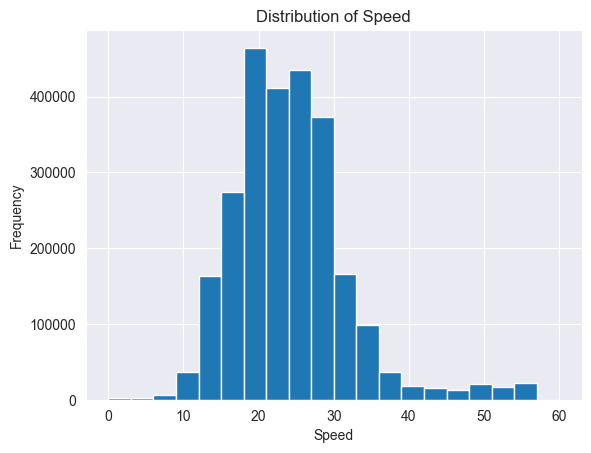

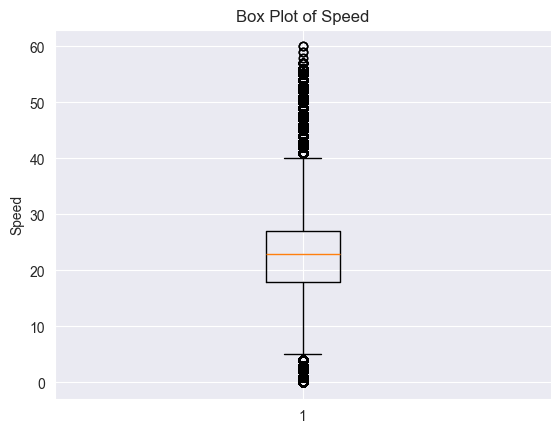

ValueError: could not convert string to float: '04/01/2018 12:01:06 AM'

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
plt.hist(local_traffic_merged['SPEED'], bins=20)
plt.title('Distribution of Speed')
plt.xlabel('Speed')
plt.ylabel('Frequency')
plt.show()

# Box Plot
plt.boxplot(local_traffic_merged['SPEED'])
plt.title('Box Plot of Speed')
plt.ylabel('Speed')
plt.show()

# Heatmap for correlation
corr_matrix = local_traffic_merged.corr()
sns.heatmap(corr_matrix)
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [ ]:
local_traffic_merged